In [1]:
import time
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from pynq import Overlay

path = "bitstreams/resnet50/live_instrumentation"
bitstream = path + "/finn-accel.bit"

# Program FPGA
ol = Overlay(bitstream, download=True, device=None)

In [2]:
### Sanity checks
# We expect 3 AXI-Lite peripherals next to the virtual FIFOs: instrumentation_wrap_0, axi_gpio_0 (for reset), zynq_ps
# We don't expect any additional FINN SDPs with AXI-Lite interface, such as runtime-writable weights
print("#FIFO IP detected: %d" % (len(ol.ip_dict.keys()) - 3))

# We expect a fifo_widths.json file exported by FINN listing the width of each FIFO, e.g.,
# {'fifo_widths': {'StreamingFIFO_hls_0': 8, 'StreamingFIFO_hls_1': 32, 'StreamingFIFO_hls_2': 24}}
with open(path + "/fifo_widths.json", "r") as f:
    fifo_info = json.load(f)
print("#FIFO width information found: %d" % len(fifo_info["fifo_widths"]))

#FIFO IP detected: 266
#FIFO width information found: 266


In [3]:
### Instrumentation driver
# Register map
#ap_uint<32>  cfg,   	// [0] - 0:hold, 1:lfsr; [31:16] - LFSR seed
#ap_uint<32> &status,	// [0] - timestamp overflow; [1] - timestamp underflow
#ap_uint<32> &latency,
#ap_uint<32> &interval,
#ap_uint<32> &checksum,
#ap_uint<32> &min_latency

def read_register(ol, name):
    return ol.instrumentation_wrap_0.read(offset=ol.ip_dict["instrumentation_wrap_0"]["registers"][name]["address_offset"])

def write_register(ol, name, value):
    return ol.instrumentation_wrap_0.write(offset=ol.ip_dict["instrumentation_wrap_0"]["registers"][name]["address_offset"], value=value)

def observe_instrumentation(debug_print=True):
    status_reg = read_register(ol, "status")
    chksum_reg = read_register(ol, "checksum")
    min_latency = read_register(ol, "min_latency")
    latency = read_register(ol, "latency")
    interval =  read_register(ol, "interval")

    frame = (chksum_reg >> 24) & 0x000000ff
    checksum = chksum_reg & 0x00ffffff
    overflow_err = (status_reg & 0x00000001) != 0
    underflow_err = (status_reg & 0x00000002) != 0

    if debug_print:
        print("---INSTRUMENTATION_REPORT---")
        if overflow_err or underflow_err:
            print("Status ERROR")
            print("Overflow error: %s" % overflow_err)
            print("Underflow error: %s" % underflow_err)
        else:
            print("Status OK")
        print("Frame number (8-bit): %d" % frame)
        print("Checksum: 0x%06x" % checksum)
        print("Min Latency (cycles): %d" % min_latency)
        print("Latency (cycles): %d" % latency)
        print("Interval (cycles): %d" % interval)
        print("----------------------------")

    return (overflow_err, underflow_err, frame, checksum, min_latency, latency, interval)

def start_accelerator():
    lfsr_seed = 0x00010000 # upper 16 bits
    write_register(ol, "cfg", lfsr_seed + 1) # start operation

### Virtual FIFO driver
# Register map
mode_offset = 0x10
depth_offset = 0x18
occupancy_offset = 0x20
occupancy_ctrl_offset = 0x24
max_occupancy_offset = 0x30
max_occupancy_ctrl_offset = 0x34

def configure_fifo(ol, i, mode, depth = 2):
    ip_name = "StreamingDataflowPartition_%d" % i
    getattr(ol, ip_name).write(offset=mode_offset, value = mode)
    getattr(ol, ip_name).write(offset=depth_offset, value = depth)

def total_fifo_size(depths):
    # Assuming FIFO SDP/AXI-Lite interfaces are ordered consistently with FIFO IDs
    total_size_bits = 0
    for i, depth in enumerate(depths):
        total_size_bits += depth * fifo_info["fifo_widths"]["StreamingFIFO_hls_%d" % i]
    total_size_kB = total_size_bits / 8.0 / 1000.0
    return total_size_kB

### GPIO Reset Driver
def reset_accelerator():
    ol.axi_gpio_0.write(offset=ol.ip_dict["axi_gpio_0"]["registers"]["GPIO_DATA"]["address_offset"], value=0)

In [4]:
### Iterative FIFO-sizing function
def size_iteratively(start_depth, iteration_runtime, reduction_factor = 0.5):
    num_fifos = len(fifo_info["fifo_widths"])
    fifo_minimum_reached = [False] * num_fifos
    
    if isinstance(start_depth, list):
        # Individual start depth for each FIFO has been supplied
        fifo_depths = start_depth
    else:
        # Initialize all depths to the same start depth
        fifo_depths = [start_depth] * num_fifos
    
    # Reset accelerator and configure FIFOs
    reset_accelerator()
    for i in range(0, num_fifos):
        configure_fifo(ol, i, mode = 1, depth = fifo_depths[i])

    # Run once to determine target interval
    start_accelerator()
    time.sleep(1)
    (overflow_err, underflow_err, frame, checksum, min_latency, latency, interval) = observe_instrumentation(False)
    log_total_fifo_size = [int(total_fifo_size(fifo_depths))]
    log_interval = [interval]
    log_min_latency = [min_latency]
    log_latency = [latency]
    target_interval = interval
    
    # Iteratively reduce FIFO depth until all FIFOs are minimized
    iteration = 0
    start_time = time.time()
    while not all(fifo_minimum_reached):
        for fifo_id in range(0, num_fifos):
            if not fifo_minimum_reached[fifo_id]:
                fifo_depth_before = fifo_depths[fifo_id]
                fifo_depths[fifo_id] = int(fifo_depths[fifo_id] * reduction_factor)

                # Reset accelerator
                reset_accelerator()

                # Configure all FIFOs
                for i in range(0, num_fifos):
                    configure_fifo(ol, i, mode = 1, depth = fifo_depths[i])

                # Start accelerator
                start_accelerator()

                # Let it run
                time.sleep(iteration_runtime)

                # Check if throughput dropped or deadlock occured 
                (overflow_err, underflow_err, frame, checksum, min_latency, latency, interval) = observe_instrumentation(False)

                if interval > target_interval or interval == 0 or overflow_err or underflow_err:
                    # Revert depth reduction and mark FIFO as minimized
                    fifo_depths[fifo_id] = fifo_depth_before
                    fifo_minimum_reached[fifo_id] = True
                else:
                    log_total_fifo_size.append(int(total_fifo_size(fifo_depths)))
                    log_interval.append(interval)
                    log_min_latency.append(min_latency)
                    log_latency.append(latency) 

                if fifo_depths[fifo_id] == 1:
                    fifo_minimum_reached[fifo_id] = True

                # Report status
                clear_output(wait=True)
                print("Iteration: %d" % iteration)
                print("Reducing depth of FIFO: %d/%d" % (fifo_id, num_fifos))
                print("Numer of minimized FIFOs: %d/%d" % (sum(fifo_minimum_reached), num_fifos))
                print("Interval: %d" % log_interval[-1])
                print("Min. latency / latency: %d/%d" % (log_min_latency[-1], log_latency[-1]))
                print("Total FIFO Size (kB): %d" % log_total_fifo_size[-1])

        iteration += 1

    end_time = time.time()
    print("Done (%d seconds)" % int(end_time - start_time))
    
    return fifo_depths, log_total_fifo_size, log_interval, log_min_latency, log_latency

In [5]:
### Attempt to determine start depth for all FIFOs automatically
# If it doesn't find a working setting, start depth must be set manually, potentially on per-FIFO basis
start_depth = 64
last_interval = 0
start_depth_found = False

while not start_depth_found:
    print("Testing start depth of %d" % start_depth)
    reset_accelerator()

    # Configure FIFOs
    num_fifos = len(fifo_info["fifo_widths"])
    for i in range(0, num_fifos):
        configure_fifo(ol, i, mode = 1, depth = start_depth)
    
    # Start accelerator and let it run for a long time
    start_accelerator()
    time.sleep(1)
    
    # Examine performance
    (overflow_err, underflow_err, frame, checksum, min_latency, latency, interval) = observe_instrumentation()
    if interval > 0 and interval == last_interval and not overflow_err and not underflow_err:
        # Accelerator runs with stable interval, reset to previous start depth
        start_depth_found = True
        start_depth = last_start_depth
    else:
        # Start depth is still too small, increase for next try
        last_start_depth = start_depth
        start_depth = start_depth * 2
    
    last_interval = interval
    
# Determine runtime per iteration based on performance, so that stable-state is guaranteed
# Use a simple overestimation for now to be safe
iteration_runtime = max(0.01, (min_latency * 5) * 10 / 1000 / 1000 / 1000)

print("Determined start depth for all FIFOs: %d" % start_depth)
print("Determined iteration runtime based on performance: %f s" % iteration_runtime)

Testing start depth of 64
---INSTRUMENTATION_REPORT---
Status OK
Frame number (8-bit): 0
Checksum: 0x000000
Min Latency (cycles): 4294967295
Latency (cycles): 0
Interval (cycles): 0
----------------------------
Testing start depth of 128
---INSTRUMENTATION_REPORT---
Status OK
Frame number (8-bit): 0
Checksum: 0x000000
Min Latency (cycles): 4294967295
Latency (cycles): 0
Interval (cycles): 0
----------------------------
Testing start depth of 256
---INSTRUMENTATION_REPORT---
Status OK
Frame number (8-bit): 0
Checksum: 0x000000
Min Latency (cycles): 4294967295
Latency (cycles): 0
Interval (cycles): 0
----------------------------
Testing start depth of 512
---INSTRUMENTATION_REPORT---
Status OK
Frame number (8-bit): 0
Checksum: 0x000000
Min Latency (cycles): 4294967295
Latency (cycles): 0
Interval (cycles): 0
----------------------------
Testing start depth of 1024
---INSTRUMENTATION_REPORT---
Status OK
Frame number (8-bit): 0
Checksum: 0x000000
Min Latency (cycles): 4294967295
Latency (c

In [6]:
### First pass
(fifo_depths,
 log_total_fifo_size,
 log_interval,
 log_min_latency,
 log_latency) = size_iteratively(start_depth, iteration_runtime)

Iteration: 12
Reducing depth of FIFO: 265/266
Numer of minimized FIFOs: 266/266
Interval: 903174
Min. latency / latency: 2549314/2580777
Total FIFO Size (kB): 244
Done (389 seconds)


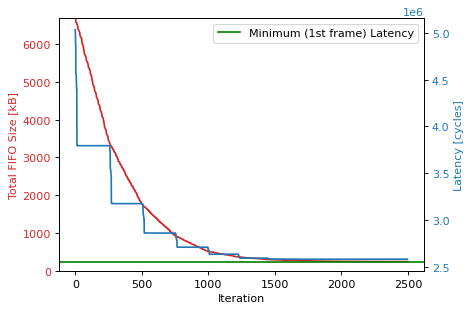

In [7]:
### Visualize results
mpl.rcParams['figure.dpi'] = 80
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Total FIFO Size [kB]', color=color)
ax1.plot(range(len(log_total_fifo_size)), log_total_fifo_size, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, max(log_total_fifo_size))
         
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Latency [cycles]', color=color)
ax2.plot(range(len(log_total_fifo_size)), log_latency, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(0, max(log_latency))

ax2.axhline(log_min_latency[0], color="green", label="Minimum (1st frame) Latency")
ax2.legend()

plt.tight_layout()
plt.savefig('fifo_iterative_graph.png', dpi = 300)
plt.show()

In [8]:
### Optional second pass for fine-tuning
(fifo_depths,
 log_total_fifo_size,
 log_interval,
 log_min_latency,
 log_latency) = size_iteratively(fifo_depths, iteration_runtime, reduction_factor = 0.95)

Iteration: 11
Reducing depth of FIFO: 48/266
Numer of minimized FIFOs: 266/266
Interval: 903174
Min. latency / latency: 2549314/2580781
Total FIFO Size (kB): 226
Done (49 seconds)


In [9]:
### Display resulting FIFO depths
print("FIFO        DEPTH | SIZE")
for fifo, depth in enumerate(fifo_depths):
    size = depth * fifo_info["fifo_widths"]["StreamingFIFO_hls_%d" % fifo]
    print("FIFO %03d: "%(fifo) + ("%d"%(depth)).rjust(7) + " | %d"%(size))

FIFO        DEPTH | SIZE
FIFO 000:       1 | 24
FIFO 001:       2 | 48
FIFO 002:       2 | 48
FIFO 003:      16 | 2048
FIFO 004:       8 | 64
FIFO 005:       2 | 16
FIFO 006:       8 | 64
FIFO 007:      32 | 256
FIFO 008:      32 | 128
FIFO 009:      32 | 128
FIFO 010:       2 | 8
FIFO 011:     128 | 8192
FIFO 012:       1 | 32
FIFO 013:       1 | 2
FIFO 014:      16 | 128
FIFO 015:     256 | 2048
FIFO 016:       2 | 16
FIFO 017:       2 | 16
FIFO 018:     355 | 45440
FIFO 019:       1 | 4
FIFO 020:       4 | 256
FIFO 021:       1 | 8
FIFO 022:       1 | 10
FIFO 023:       1 | 8
FIFO 024:    4096 | 32768
FIFO 025:       1 | 8
FIFO 026:       1 | 4
FIFO 027:    4096 | 32768
FIFO 028:       1 | 64
FIFO 029:     256 | 1024
FIFO 030:     256 | 2048
FIFO 031:       2 | 16
FIFO 032:       2 | 16
FIFO 033:     288 | 36864
FIFO 034:       1 | 4
FIFO 035:       1 | 64
FIFO 036:       1 | 8
FIFO 037:       1 | 10
FIFO 038:       4 | 32
FIFO 039:       4 | 32
FIFO 040:    4096 | 32768
FIFO 041:  

In [10]:
### Export for use in FINN
fifo_depth_export = {}
for fifo, depth in enumerate(fifo_depths):
    fifo_depth_export["StreamingFIFO_rtl_%d" % fifo] = {}
    # Try to account for additional registers introduced by virtual FIFO HLS implementation
    fifo_depth_export["StreamingFIFO_rtl_%d" % fifo]["depth"] = depth + 4

with open("fifo_depth_export.json", "w") as f:
    json.dump(fifo_depth_export, f, indent=2)